In [7]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from gensim.utils import tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [9]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,[1] Chaque théologien devrait être à l’aise avec les notions suivantes :,chaque théologien devrait être aise notion suivant,philosophy,72,1
1,1,"Article intéressant, mais je ne vois pas à quel moment intervient le libre arbitre s’il y a prédestination. Qu’elle soit première ou seconde. De toute manière, la science d’aujourd’hui t’émet sérieusement en cause le libre arbitre, mais c’est un autre sujet.",article intéressant vois quel moment intervient libre arbitre a prédestination première seconde toute manière science aujourdhui émet sérieusement cause libre arbitre autre sujet,philosophy,258,1
...,...,...,...,...,...,...
3664,3664,"L’erreur de cette objection est de se concentrer sur un mal particulier en oubliant qu’ils sont tous connectés à un plan général (le plan de Dieu, ou la Providence), et que Dieu travaille chacun de ces détails non en eux-même, mais par rapport au plan plus global. Ainsi, Thomas d’Aquin dit :",lerreur cette objection concentrer mal particulier oubliant tous connectés plan général plan dieu providence dieu travaille chacun détail non eux-même rapport plan plus global ainsi thomas aquin dit,philosophy,292,1
3665,3665,"A ceci près que nos traductions et la critique textuelle ont évolué depuis la vulgate. En réalité il est écrit: « Toutes choses ont été faites par elle, et **rien de ce qui a été fait n’a été fait sans elle.** **En elle était la vie** , et la vie était la lumière des hommes. » 1 Jean 1.3-4. Cette différence de traduction ne remet pas en cause l’enseignement de Thomas. Voici le raisonnement, très court, très digeste:",a ceci près traduction critique textuelle évolué depuis vulgate réalité écrit « toutes chose faites rien a fait a fait sans vie vie lumière homme » jean - cette différence traduction remet cause enseignement thomas voici raisonnement très court très digeste,philosophy,419,1


In [10]:
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [11]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [23]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_skip_gram = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=1) #modele skip-gram
model_cbow = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele CBOW

In [13]:
tokens

0                                                                                                                                                                                                                                                        [chaque, théologien, devrait, être, aise, notion, suivant]
1                                                                                                        [article, intéressant, vois, quel, moment, intervient, libre, arbitre, a, prédestination, première, seconde, toute, manière, science, aujourdhui, émet, sérieusement, cause, libre, arbitre, autre, sujet]
                                                                                                                                                           ...                                                                                                                                                     
3664                                                                        

In [24]:
words_vectors_skip_gram = model_skip_gram.wv

In [13]:
model.wv.most_similar("maxime", topn=10)

[('mémoire', 0.26893195509910583),
 ('perspective', 0.2568460702896118),
 ('comment', 0.2226698398590088),
 ('hypostatique', 0.21855299174785614),
 ('accomplissement', 0.21523335576057434),
 ('accessible', 0.2086881846189499),
 ('compréhension', 0.2060597687959671),
 ('relire', 0.20239178836345673),
 ('elles', 0.19563530385494232),
 ('départ', 0.18949609994888306)]

In [8]:
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

2924


In [81]:
type(model.wv)
model.wv[0]
model.wv[0].shape

(200,)

In [11]:
model.wv.key_to_index
model.wv.index_to_key[100]
type(model.wv.index_to_key)

list

In [123]:
len(model.wv.index_to_key)

2924

In [124]:
type(model.wv)

gensim.models.keyedvectors.KeyedVectors

In [12]:
len(words_vectors)
len(words_vectors.index_to_key[:len(words_vectors)])
type(words_vectors[words_vectors.index_to_key[:len(words_vectors)]])
words_vectors[words_vectors.index_to_key[:len(words_vectors)]].shape

(2924, 200)

In [8]:
words_vectors[words_vectors.index_to_key[:len(words_vectors)]]

array([[-2.68113625e-04,  1.18215081e-04,  2.55167484e-03, ...,
        -1.19575742e-03, -4.75504762e-03,  2.25293869e-03],
       [ 4.72819811e-05,  1.53865933e-03, -3.40632326e-03, ...,
        -3.72379413e-03, -1.25303748e-03, -2.77493242e-03],
       [-3.56950751e-03,  6.20515319e-04, -3.58835817e-03, ...,
        -4.34601074e-03,  1.48075819e-03, -3.33794951e-03],
       ...,
       [ 1.63632515e-03, -1.87310809e-03,  4.53326706e-04, ...,
         5.80255990e-04, -2.01740023e-03,  1.26625178e-03],
       [-4.64244140e-03, -1.38949152e-04, -2.22848775e-03, ...,
         4.29207692e-03, -4.04914375e-03, -1.21603014e-04],
       [-7.28440282e-05, -3.72289657e-03,  2.80575739e-04, ...,
        -7.81719689e-04,  1.53545977e-03,  4.93388064e-03]], dtype=float32)

In [18]:
#TSNE en 2D apres reduction svd en 50 dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=30, verbose=1)
tsne_results = tsne.fit_transform(words_vectors_skip_gram[words_vectors_skip_gram.index_to_key[:len(words_vectors_skip_gram)]])
tsne_results

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2924 samples in 0.002s...
[t-SNE] Computed neighbors for 2924 samples in 0.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2924
[t-SNE] Computed conditional probabilities for sample 2000 / 2924
[t-SNE] Computed conditional probabilities for sample 2924 / 2924
[t-SNE] Mean sigma: 0.008756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.476357
[t-SNE] KL divergence after 900 iterations: 3.738301


array([[  7.9785223 , -13.49791   ,   1.2470512 ],
       [-39.20902   ,  17.576405  ,  -7.868293  ],
       [ 38.465553  ,  14.647138  ,   7.6627    ],
       ...,
       [ 27.366573  ,  -0.49108687,   0.6454885 ],
       [-38.73966   ,   9.480808  ,  12.716627  ],
       [-42.971085  ,  13.650212  , -10.092126  ]], dtype=float32)

In [152]:
tsne_results.shape
# tsne_results[:,0].shape
# tsne_results[:,1].shape

(2924, 2)

In [26]:
#Plot 3D de certains mots (car impossible de tous les afficher sinon illisible)
n_kept = 150
import plotly.express as px
fig = px.scatter_3d(corpus, x=tsne_results[0:n_kept,0], y=tsne_results[0:n_kept,1], z=tsne_results[0:n_kept,2],
              text=words_vectors_skip_gram.index_to_key[0:n_kept])
fig.show()

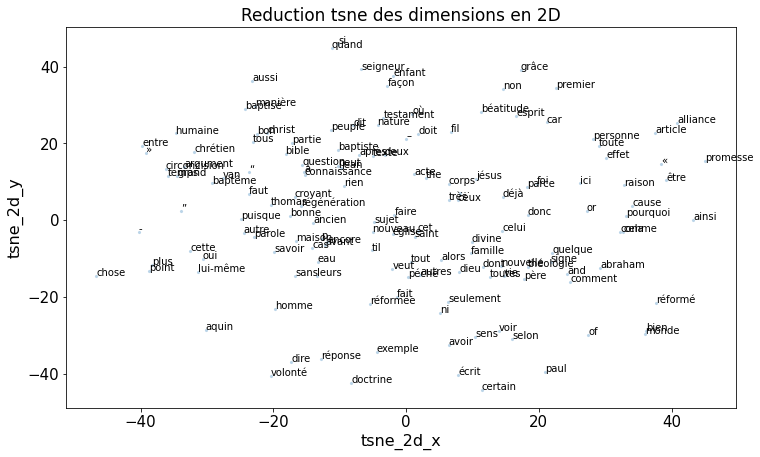

In [27]:
# Sans label
plt.figure(figsize=(12, 7))
sb.scatterplot(
    x=tsne_results[0:n_kept,0], y=tsne_results[0:n_kept,1],
    legend="auto",
    alpha=0.3,
    s=10
)
for i in range(n_kept):
    plt.text(x=tsne_results[i,0], y=tsne_results[i,1], s=words_vectors.index_to_key[i])

plt.xlabel("tsne_2d_x", size=16)
plt.ylabel("tsne_2d_y", size=16)
plt.title("Reduction tsne des dimensions en 2D", size=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [16]:
print(tsne_results[0:50:,0])

[ 32.97364     27.86875      2.6578183   -6.156161    26.759222
  26.850883    16.1331     -18.113335   -18.714615    22.738516
 -17.732666    30.788158   -21.100252    21.00191     40.18455
 -25.64658     11.441761    26.25866     -8.396498    24.155148
   2.2062364  -35.837776   -31.808994    -3.1559381  -15.883595
  11.889427     0.16937323 -17.269344    -4.664543     2.3588793
 -15.474083    14.938675    12.966424    36.691887    32.03494
 -28.764671    14.556421    -5.2187657  -16.172247    -2.6972094
 -24.54941     39.68088     -3.7747867   27.805323    16.432642
  -5.650859    14.336708    -2.8012807   -1.4311023  -29.907084  ]


Utilisation des features word2vec pour la classification

sources :
http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html